##### 0. Setup Colab and Google-Drive.

In [1]:
%cd /content/drive/MyDrive/Computer\ Vision/Instance\ Segmentation

/content/drive/MyDrive/Computer Vision/Instance Segmentation


##### 1. Setup for downloading dataset from kaggle.

In [2]:
from google.colab import files
files.upload() 

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

In [3]:
# search for dataset in kaggle.
!kaggle datasets list -s "COVID-19 Radiography Database"

ref                                                           title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
tawsifurrahman/covid19-radiography-database                   COVID-19 Radiography Database                     778MB  2022-03-19 13:38:42          59745        790  1.0              
andyczhao/covidx-cxr2                                         COVIDx CXR-2                                       13GB  2022-06-02 13:22:23           6385        156  0.875            
anasmohammedtahir/covidqu                                     COVID-QU-Ex Dataset                                 1GB  2022-02-01 06:23:01           2159         45  0.6875           
mloey1/covid19-chest-ct-image-augmentation-gan-dataset        COVID-19 Chest CT 

##### 2. Download dataset from kaggle.

In [4]:
import os

zipfile_path = os.path.join("/", "home")
!kaggle datasets download --force -d tawsifurrahman/covid19-radiography-database -p {zipfile_path}

100% 775M/778M [00:20<00:00, 42.5MB/s]
100% 778M/778M [00:20<00:00, 40.0MB/s]


##### 3. Extract Dataset.

In [5]:
from zipfile import ZipFile

zipfile_name = "covid19-radiography-database.zip"
dataset = os.path.join(zipfile_path, zipfile_name)

with ZipFile(dataset, "r") as zip:
    # exctract in same path as zipfile
    zip.extractall(zipfile_path)

print(os.listdir(zipfile_path))

['COVID-19_Radiography_Dataset', 'covid19-radiography-database.zip']


##### 4. Setup Paths.

In [6]:
# Sine we are just intrested in instance-segementation here,  we do not care about the class of images.
# So we move all images into a same folder and move their masks to another folder.
import shutil
from tqdm import tqdm

paths = {
    "images": os.path.join("/", "home", "images"),
    "masks" : os.path.join("/", "home", "masks"),
}

for fname, path in paths.items():
    os.makedirs(path, exist_ok=True)
    print(f"folder `{fname}` created.")

current_folders = {
    "COVID"           : os.path.join("/", "home", "COVID-19_Radiography_Dataset", "COVID"),
    "Lung_Opacity"    : os.path.join("/", "home", "COVID-19_Radiography_Dataset", "Lung_Opacity"),
    "Normal"          : os.path.join("/", "home", "COVID-19_Radiography_Dataset", "Normal"),
    "Viral_Pneumonia" : os.path.join("/", "home", "COVID-19_Radiography_Dataset", "Viral Pneumonia"),
}
print("paths were set.")

folder `images` created.
folder `masks` created.
paths were set.


##### 5. Move Images.

In [7]:
for folder_name, path in current_folders.items():
    print(f"*** Moving images of `{folder_name}` ***")
    for subfolder in ("images", "masks"):
        print(f"{subfolder}...", end=" ")
        subpath = os.path.join(path, subfolder)
        files = os.listdir(subpath)
        files = [os.path.join(subpath, f) for f in files]
        for f in tqdm(files):
            shutil.move(f, paths[subfolder])
    
    print("done.")
    print()

*** Moving images of `COVID` ***
images... 

100%|██████████| 3616/3616 [00:00<00:00, 26700.03it/s]


masks... 

100%|██████████| 3616/3616 [00:00<00:00, 24571.97it/s]


done.

*** Moving images of `Lung_Opacity` ***
images... 

100%|██████████| 6012/6012 [00:00<00:00, 27549.40it/s]


masks... 

100%|██████████| 6012/6012 [00:00<00:00, 24605.90it/s]


done.

*** Moving images of `Normal` ***
images... 

100%|██████████| 10192/10192 [00:00<00:00, 25924.96it/s]


masks... 

100%|██████████| 10192/10192 [00:00<00:00, 26799.45it/s]


done.

*** Moving images of `Viral_Pneumonia` ***
images... 

100%|██████████| 1345/1345 [00:00<00:00, 27206.58it/s]


masks... 

100%|██████████| 1345/1345 [00:00<00:00, 28999.54it/s]

done.



##### 6. Visualize some sample images.

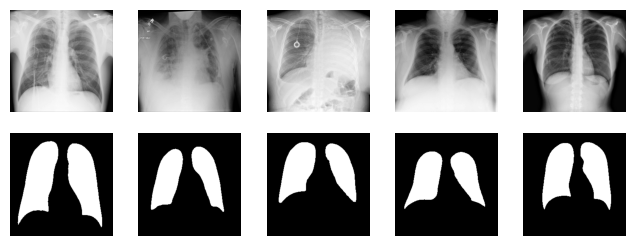

In [8]:
import matplotlib.pyplot as plt

from PIL import Image
from random import sample
from matplotlib.pyplot import figure

def load_img(path: str):
    img = Image.open(path)
    img.load()
    data = np.asarray(img, dtype="int32")
    return data

num_samples = 5
samples = sample(os.listdir(paths["images"]), num_samples)

figure(figsize=(8, 3), dpi=100)
for i in range(num_samples):
    img = load_img(os.path.join(paths["images"], samples[i]))
    mask = load_img(os.path.join(paths["masks"], samples[i]))
    plt.subplot(2, num_samples, i+1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")

    plt.subplot(2, num_samples, i+num_samples+1)
    plt.imshow(mask)
    plt.axis("off")

##### 7. Create tf-dataset.

In [9]:
import tensorflow as tf

width, height  = 256, 256
batch_size = 32

train_imgs = tf.keras.utils.image_dataset_from_directory(
    paths['images'],
    color_mode="grayscale",
    seed=1,
    image_size=(width, height),
    batch_size=batch_size,
    validation_split=0.1,
    subset="training",
    shuffle=False,
    label_mode=None,
)
print()
train_masks = tf.keras.utils.image_dataset_from_directory(
    paths['masks'],
    color_mode="rgb",
    seed=1,
    image_size=(width, height),
    batch_size=batch_size,
    validation_split=0.1,
    subset="training",
    shuffle=False,
    label_mode=None,
)
print()
valid_imgs = tf.keras.utils.image_dataset_from_directory(
    paths['images'],
    color_mode="grayscale",
    seed=1,
    image_size=(width, height),
    batch_size=batch_size,
    validation_split=0.1,
    subset="validation",
    shuffle=False,
    label_mode=None,
)
print()
valid_masks = tf.keras.utils.image_dataset_from_directory(
    paths['masks'],
    color_mode="rgb",
    seed=1,
    image_size=(width, height),
    batch_size=batch_size,
    validation_split=0.1,
    subset="validation",
    shuffle=False,
    label_mode=None,
)

train_ds = tf.data.Dataset.zip((train_imgs, train_masks))
valid_ds = tf.data.Dataset.zip((valid_imgs, valid_masks))

Found 21165 files belonging to 1 classes.
Using 19049 files for training.

Found 21165 files belonging to 1 classes.
Using 19049 files for training.

Found 21165 files belonging to 1 classes.
Using 2116 files for validation.

Found 21165 files belonging to 1 classes.
Using 2116 files for validation.


##### 8. Preprocessing.

In [10]:
train_ds = train_ds.map(lambda x, y: (x/255., y/255.)).prefetch(1)
valid_ds = valid_ds.map(lambda x, y: (x/255., y/255.)).prefetch(1)

##### 9. Define UNET Model.

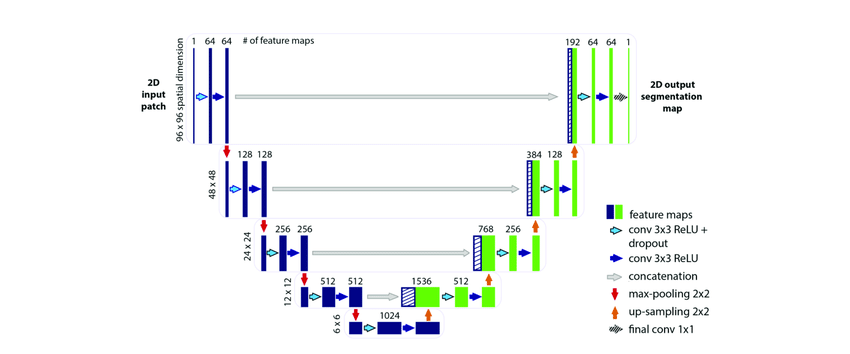

In [11]:
from IPython.display import Image

# A quick glance at UNET architecture.
# We have to change the layers dimension to adopt it to the images in out dataset.
Image("unet_architecture_.png")

In [12]:
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Concatenate

model_input = Input(shape=(height, width, 1))

#  ----- Downsampling ---- #
d1 = Conv2D(16, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(model_input)
d1 = Dropout(0.1)(d1)
d1 = Conv2D(16, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(d1)
p1 = MaxPooling2D((2, 2))(d1)  # (128, 128, 16)

d2 = Conv2D(32, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(p1)
d2 = Dropout(0.1)(d2)
d2 = Conv2D(32, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(d2)
p2 = MaxPooling2D((2, 2))(d2)  # (64, 64, 32)

d3 = Conv2D(64, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(p2)
d3 = Dropout(0.1)(d3)
d3 = Conv2D(32, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(d3)
p3 = MaxPooling2D((2, 2))(d3)  # (32, 32, 64)

d4 = Conv2D(128, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(p3)
d4 = Dropout(0.1)(d4)
d4 = Conv2D(32, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(d4)
p4 = MaxPooling2D((2, 2))(d4)  # (16, 16, 128)

d5 = Conv2D(256, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(p4)
d5 = Dropout(0.1)(d5)
d5 = Conv2D(32, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(d5)  # (16, 16, 256)

#  ----- Upsampling ---- #
u6 = Conv2DTranspose(128, (2, 2), strides=2, padding="same")(d5)   # (32, 32, 128)
u6 = Concatenate()([u6, d4])
u6 = Conv2D(128, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(u6)
u6 = Dropout(0.1)(u6)
u6 = Conv2D(128, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(u6) 

u7 = Conv2DTranspose(64, (2, 2), strides=2, padding="same")(u6)    # (64, 64, 64)
u7 = Concatenate()([u7, d3])
u7 = Conv2D(64, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(u7)
u7 = Dropout(0.1)(u7)
u7 = Conv2D(64, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(u7)

u8 = Conv2DTranspose(32, (2, 2), strides=2, padding="same")(u7)    # (128, 128, 32)
u8 = Concatenate()([u8, d2])
u8 = Conv2D(32, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(u8)
u8 = Dropout(0.1)(u8)
u8 = Conv2D(32, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(u8)

u9 = Conv2DTranspose(16, (2, 2), strides=2, padding="same")(u8)   # (256, 256, 16)
u9 = Concatenate()([u9, d1])
u9 = Conv2D(16, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(u9)
u9 = Dropout(0.1)(u9)
u9 = Conv2D(16, 3, strides=1, padding="same", activation="relu", kernel_initializer="he_normal")(u9)

outputs = Conv2D(3, (1, 1), activation="sigmoid")(u9)

unet = tf.keras.Model(model_input, outputs)

##### 10. Compile the Model and define some callbacks.

In [13]:
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_checkpoint.h5")
unet.compile(loss="binary_crossentropy", optimizer="adam")

print(unet.count_params())

793619


##### 11. Train the Model.

In [14]:
history = unet.fit(train_ds, epochs=20, callbacks=[model_checkpoint_cb])

Epoch 1/20
596/596 [==============================] - 188s 294ms/step - loss: 0.1311
Epoch 2/20
596/596 [==============================] - 177s 297ms/step - loss: 0.0492
Epoch 3/20
596/596 [==============================] - 178s 299ms/step - loss: 0.0316
Epoch 4/20
596/596 [==============================] - 178s 298ms/step - loss: 0.0257
Epoch 5/20
596/596 [==============================] - 178s 298ms/step - loss: 0.0233
Epoch 6/20
596/596 [==============================] - 178s 299ms/step - loss: 0.0210
Epoch 7/20
596/596 [==============================] - 178s 299ms/step - loss: 0.0198
Epoch 8/20
596/596 [==============================] - 178s 298ms/step - loss: 0.0191
Epoch 9/20
596/596 [==============================] - 178s 298ms/step - loss: 0.0179
Epoch 10/20
596/596 [==============================] - 178s 298ms/step - loss: 0.0174
Epoch 11/20
596/596 [==============================] - 178s 298ms/step - loss: 0.0172
Epoch 12/20
596/596 [==============================] - 178s 298

##### 12. Save the model.

In [15]:
unet.save("unet_covid19_radiographi_segmentation.h5")

###### 13. Load the trained model.

In [16]:
unet_loaded = tf.keras.models.load_model("unet_covid19_radiographi_segmentation.h5")

##### 14. Evaluate the model.

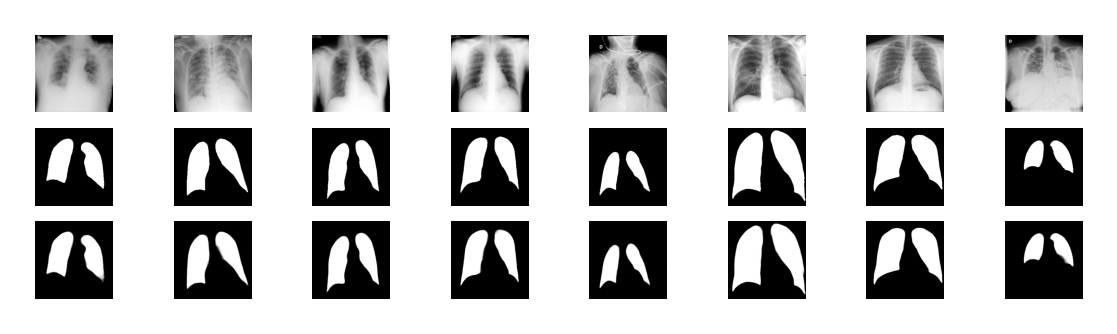

In [ ]:
# Evaluate on train set
import numpy as np

for batch in train_ds.take(1):
    pass

X, Y = batch
Y_preds = unet_loaded(X).numpy()

figure(figsize=(4, 1), dpi=350)
for i in range(8):
    plt.subplot(3, 8, i+1)
    plt.imshow(np.squeeze(X[i]), cmap="gray")
    plt.axis("off")

    plt.subplot(3, 8, i+9)
    plt.imshow(Y[i])
    plt.axis("off")

    plt.subplot(3, 8, i+17)
    plt.imshow(Y_preds[i])
    plt.axis("off")

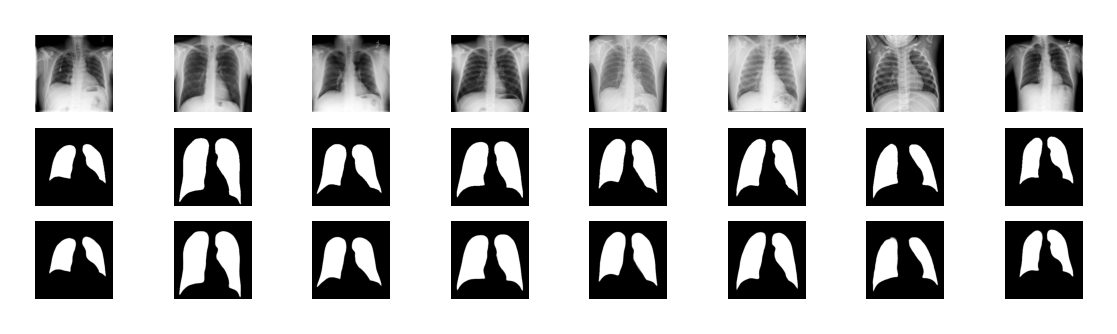

In [17]:
# Evalute on test set.
for batch in valid_ds.take(1):
    pass

X, Y = batch
Y_preds = unet_loaded(X).numpy()

figure(figsize=(4, 1), dpi=350)
for i in range(8):
    plt.subplot(3, 8, i+1)
    plt.imshow(np.squeeze(X[i]), cmap="gray")
    plt.axis("off")

    plt.subplot(3, 8, i+9)
    plt.imshow(Y[i])
    plt.axis("off")

    plt.subplot(3, 8, i+17)
    plt.imshow(Y_preds[i])
    plt.axis("off")